In [15]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


In [16]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('nyc_taxi_notebook_04') \
    .getOrCreate()

In [17]:
spark.sparkContext.uiWebUrl

'http://spark-medium.europe-southwest1-a.c.de-zoomcamp-jhigaki-course.internal:4040'

In [19]:
df_yellow = spark.read\
    .parquet(f'tmp-data/pq/yellow/*/*')\
    .withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime')\
    .filter(F.col('pickup_datetime') < '2019-01-03 00:00:00') #yellow is too big, let's work with only two months

I addedd 

```python
 .filter(F.col('pickup_datetime') < '2019-01-03 00:00:00') #yellow is too big, let's work with only two months
```

so that processsing doesn't take that long, right now it takes 8min + to processs yellow dataset for 2019

# Implement summarization based on DatFrame

This is from  to [03_taxi_rides_spark](./03_taxi_rides_spark.ipynb)

In [20]:
def get_metrics_per_hour_pickup_location(df):
    return df.filter(\
        (F.col('pickup_datetime') >= '2019-01-01 00:00:00')\
        &(F.col('pickup_datetime') < '2020-01-01 00:00:00'))\
        .withColumn('pickup_hour', F.date_trunc('hour', 'pickup_datetime'))\
        .select('pickup_hour', 'PULocationID', 'DOLocationID','passenger_count', 'trip_distance','total_amount')\
        .groupBy('pickup_hour', 'PULocationID')\
        .agg(\
            F.sum('total_amount').alias('total_amount'),\
            F.sum('passenger_count').alias('passenger_count'),\
            F.sum('trip_distance').alias('trip_distance'),\
            F.count('*').alias('trip_count')\
        )\
        .orderBy('pickup_hour', 'PULocationID')
    

In [21]:
df_yellow_metrics = get_metrics_per_hour_pickup_location(df_yellow)\
    .withColumn('service_type', F.lit('yelllow'))

In [22]:
df_yellow_metrics.show(100)

+-------------------+------------+------------------+---------------+------------------+----------+------------+
|        pickup_hour|PULocationID|      total_amount|passenger_count|     trip_distance|trip_count|service_type|
+-------------------+------------+------------------+---------------+------------------+----------+------------+
|2019-01-01 00:00:00|           4|            731.72|           73.0|            136.87|        49|     yelllow|
|2019-01-01 00:00:00|           7|            332.61|           31.0|             74.12|        25|     yelllow|
|2019-01-01 00:00:00|          10|              28.6|            2.0|              6.04|         2|     yelllow|
|2019-01-01 00:00:00|          11|              18.6|            3.0|              3.59|         2|     yelllow|
|2019-01-01 00:00:00|          12|             55.55|           13.0|             12.44|         4|     yelllow|
|2019-01-01 00:00:00|          13|           1134.12|          108.0|244.71999999999997|        

Save them each to a parquet file

In [23]:
df_yellow_metrics.\
    write.parquet(f'tmp-data/pq/reports/mapReduce-comparison/yellow/data-frame/no_repartition_specified/')

In [24]:
!tree tmp-data/pq/reports/mapReduce-comparison/yellow/

tmp-data/pq/reports/mapReduce-comparison/yellow/
└── data-frame
    └── no_repartition_specified
        ├── _SUCCESS
        └── part-00000-7a8785f4-4792-46d4-90e1-d8bd66b306fe-c000.snappy.parquet

3 directories, 2 files


# With Rdds

In [25]:
rdd_yellow = df_yellow\
    .select("pickup_datetime", "PULocationID","passenger_count","trip_distance","total_amount")\
    .rdd

rdd_yellow


MapPartitionsRDD[58] at javaToPython at NativeMethodAccessorImpl.java:0

In [26]:
rdd_yellow.count()

388808

In [27]:
row_example = rdd_yellow.take(1)[0]
row_example

Row(pickup_datetime=datetime.datetime(2009, 1, 1, 0, 54, 13), PULocationID=79, passenger_count=1.0, trip_distance=9.0, total_amount=31.8)

In [28]:
row_example["pickup_datetime"]

datetime.datetime(2009, 1, 1, 0, 54, 13)

In [46]:
from datetime import datetime
start = datetime(year=2019, month=1, day=1)
finish = datetime(year=2020, month=1, day=1)

def filter_2019(row: pyspark.sql.Row)-> bool:
    return start <= row["pickup_datetime"] < finish

def prepare_for_aggregation(row: pyspark.sql.Row):
    pickup_hour = row["pickup_datetime"].replace(minute=0,second=0,microsecond=0)
    pickup_location_id = row["PULocationID"]
    key = (pickup_hour, pickup_location_id)
    total_amount = row["total_amount"]
    passenger_count = row["passenger_count"]
    trip_distance = row["trip_distance"]    
    trip_count = 1
    value = (total_amount, passenger_count, trip_distance, trip_count)
    return (key, value)

def aggregate_old(left_value, right_value):    
    left_total_amount, left_passenger_count, left_trip_distance, left_trip_count =  (x if x is not None else 0 for x in left_value) 
    right_total_amount, right_passenger_count, right_trip_distance, right_trip_count = (x if x is not None else 0 for x in right_value)
    return ( left_total_amount + right_total_amount,\
            left_passenger_count + right_passenger_count,\
            left_trip_distance + right_trip_distance,\
            left_trip_count + right_trip_count)

def aggregate(left_value, right_value): 
    def safe_sum(a, b): 
        return (a if a is not None else 0) + (b if b is not None else 0)     
    return tuple(safe_sum(l, r) for l, r in zip(left_value, right_value))


def aggregate_pythonic_old(left_value, right_value):    
    return tuple(sum(value_pairs) for value_pairs in zip(left_value, right_value))


def aggregate_pythonic(left_value, right_value):    
    return tuple(sum(x if x is not None else 0 for x in value_pairs) for value_pairs in zip(left_value, right_value))



In [30]:
transformed_row = prepare_for_aggregation(row_example)
transformed_row

((datetime.datetime(2009, 1, 1, 0, 0), 79), (31.8, 1.0, 9.0, 1))

In [31]:
result_aggregate = aggregate2(transformed_row[1], transformed_row[1])
print(result_aggregate)

(31.8, 1.0, 9.0, 1)
(63.6, 2.0, 18.0, 2)


In [32]:
result_aggregate_pythonic = aggregate(transformed_row[1], transformed_row[1])
print(result_aggregate_pythonic)

(31.8, 1.0, 9.0, 1)
(63.6, 2.0, 18.0, 2)


In [37]:
# Test data
left_value = (10, None, 20.5, 1)
right_value = (15, 7, None, 2)
expected_result = (25, 7, 20.5, 3)

# Test aggregate function
result1 = aggregate2(left_value, right_value)
assert result1 == expected_result, f"Expected {expected_result}, got {result1}"
print("aggregate function passed.")

# Test aggregate_pythonic function
result2 = aggregate_pythonic(left_value, right_value)
assert result2 == expected_result, f"Expected {expected_result}, got {result2}"
print("aggregate_pythonic function passed.")

# Assert both functions produce the same result
assert result1 == result2, f"Expected {result1} and {result2} to be equal"
print("Both functions produce the same result.")




(10, None, 20.5, 1)
aggregate function passed.
(10, None, 20.5, 1)
aggregate_pythonic function passed.
Both functions produce the same result.


In [44]:
# Test data
left_value = (10, None, 20.5, 1)
right_value = (15, 7, None, 2)
expected_result = (25, 7, 20.5, 3)


def assert_and_compare(first_function, second_function):
    # Test first function
    result1 = first_function(left_value, right_value)
    assert result1 == expected_result, f"Expected {expected_result}, got {result1}"
    print(f"{first_function.__name__} function passed.")

    # Test second function
    result2 = second_function(left_value, right_value)
    assert result2 == expected_result, f"Expected {expected_result}, got {result2}"
    print(f"{second_function.__name__} function passed.")

    # Assert both functions produce the same result
    assert result1 == result2, f"Expected {result1} and {result2} to be equal"
    print("Both functions produce the same result.")

assert_and_compare(aggregate, aggregate_pythonic)
#assert_and_compare(aggregate, aggregate_pythonic_old)
assert_and_compare(aggregate, aggregate_old)


(10, None, 20.5, 1)
aggregate function passed.
(10, None, 20.5, 1)
aggregate_pythonic function passed.
Both functions produce the same result.
(10, None, 20.5, 1)
aggregate function passed.
(10, None, 20.5, 1)
aggregate_old function passed.
Both functions produce the same result.


The `zip()` function in Python takes two or more iterable objects (like lists or tuples) and aggregates them element-wise, creating an iterator of tuples. Each tuple contains elements from the input iterables at the corresponding positions.

In [ ]:
rdd_yellow.filter(filter_2019).count()

388169

In [ ]:
84598444 - 84597002

1442

(no filter) - filtered = 1442

(shrinked the yellow dataset for Jan and Feb only)

The group by 

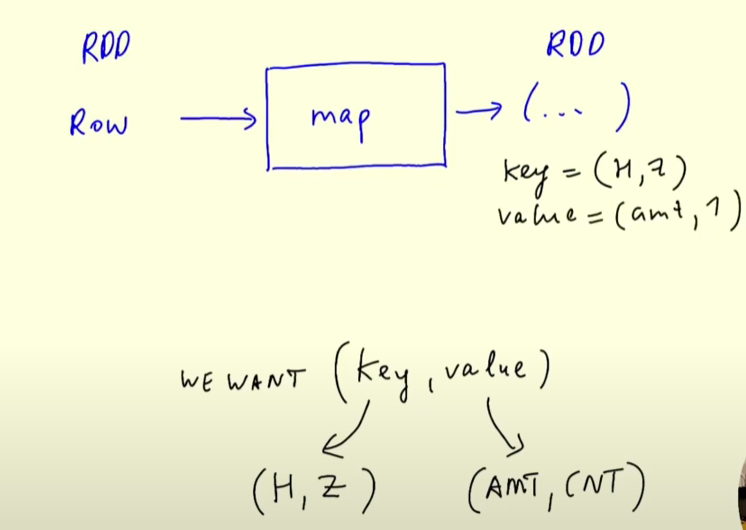

In [84]:
result = rdd_yellow\
    .filter(filter_2019)\
    .map(prepare_for_aggregation)\
    .reduceByKey(aggregate)\

result_5 = result.take(5)


In [60]:
result_5[0][0]

(datetime.datetime(2019, 1, 2, 0, 0), 229)

In [86]:

#(type(result[0]), type(result_5)) 
#type(result_5)

At this point

the aggregation has the following shape: 

Item on list = KEY, VALUE
KEY = pickup_hour, location_id
VALUE = total_amount, passenger_count, trip_distance, trip_count

If turned into a Dframe, it would have only two columns

In [87]:
result.toDF().show()

+--------------------+--------------------+
|                  _1|                  _2|
+--------------------+--------------------+
|{2019-01-02 00:00...|{428.460000000000...|
|{2019-01-01 10:00...|{1506.17999999999...|
|{2019-01-01 16:00...|{3941.13999999999...|
|{2019-01-02 18:00...|{7127.43000000001...|
|{2019-01-02 11:00...|{6333.00000000001...|
|{2019-01-01 22:00...|{5381.14000000000...|
|{2019-01-02 07:00...|{4642.31999999999...|
|{2019-01-01 14:00...|{1814.42999999999...|
|{2019-01-01 11:00...|{1923.37999999999...|
|{2019-01-02 11:00...|{4716.41000000000...|
|{2019-01-02 18:00...|{6875.65000000001...|
|{2019-01-02 18:00...|{10292.7400000000...|
|{2019-01-01 12:00...|{15585.9500000000...|
|{2019-01-02 19:00...|{15219.6900000000...|
|{2019-01-01 19:00...|{8411.23000000002...|
|{2019-01-01 16:00...|{2854.31999999999...|
|{2019-01-02 11:00...|{4524.67999999999...|
|{2019-01-02 14:00...|{1271.51999999999...|
|{2019-01-02 12:00...|{4445.64999999999...|
|{2019-01-02 10:00...|{1162.0699

In [75]:
from collections import namedtuple
MetricsRow = namedtuple("MetricsRow", ["pickup_hour", "pickup_location_id", "total_amount", "passenger_count", "trip_distance", "trip_count"])

def flatten_item_for_row(list_item):    
    return MetricsRow(\
        pickup_hour = list_item[0][0],\
        pickup_location_id = list_item[0][1],\
        total_amount = list_item[1][0],\
        passenger_count = list_item[1][1],\
        trip_distance = list_item[1][2],\
        trip_count = list_item[1][3]
    )

In [88]:
result_unpacked = rdd_yellow\
    .filter(filter_2019)\
    .map(prepare_for_aggregation)\
    .reduceByKey(aggregate)\
    .map(flatten_item_for_row)

In [89]:
result_unpacked.toDF().show()

+-------------------+------------------+------------------+---------------+------------------+----------+
|        pickup_hour|pickup_location_id|      total_amount|passenger_count|     trip_distance|trip_count|
+-------------------+------------------+------------------+---------------+------------------+----------+
|2019-01-02 00:00:00|               229|428.46000000000004|           77.0|             71.92|        34|
|2019-01-01 10:00:00|               239|1506.1799999999992|          255.0|300.94000000000005|       132|
|2019-01-01 16:00:00|               236| 3941.139999999995|          584.0|            702.21|       339|
|2019-01-02 18:00:00|               170| 7127.430000000015|          768.0|1086.3100000000002|       477|
|2019-01-02 11:00:00|               186| 6333.000000000012|          745.0|1022.1900000000005|       471|
|2019-01-01 22:00:00|               230|5381.1400000000085|          736.0| 978.6999999999998|       418|
|2019-01-02 07:00:00|                48| 4642.

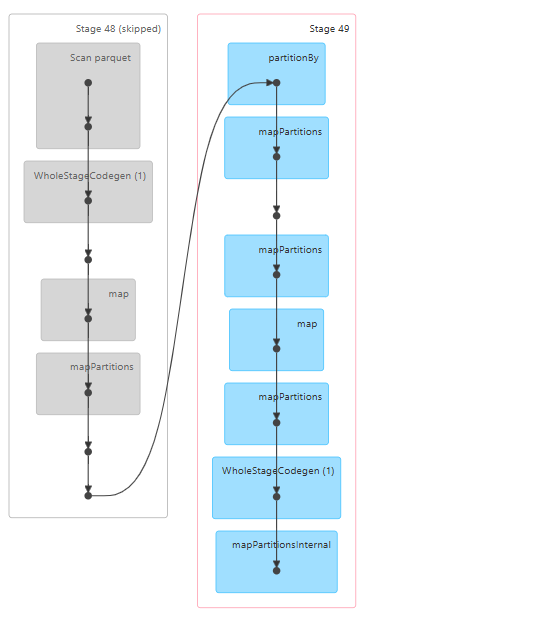

Are the datasets the same? 
df_yellow_metrics (through spark group by))
result_unpacked (through map redcuce)


df_yellow_metrics = get_metrics_per_hour_pickup_location(df_yellow)\
    

In [92]:
def compare_dataframes(df1, df2):
    # Check if schemas are equal
    if df1.schema != df2.schema:
        print("Schemas are not equal")
        print(f"Schema of df1: {df1.schema}")
        print(f"Schema of df2: {df2.schema}")
        return

    # Check for differences
    diff1 = df1.subtract(df2)
    diff2 = df2.subtract(df1)

    if diff1.count() != 0 or diff2.count() != 0:
        print("DataFrames are not equal")

        if diff1.count() != 0:
            print("Rows in df1 but not in df2:")
            diff1.show()

        if diff2.count() != 0:
            print("Rows in df2 but not in df1:")
            diff2.show()
    else:
        print("DataFrames are equal")

# Example usage
df1 = spark.createDataFrame([(1, "Alice", 100), (2, "Bob", 200)], ["id", "name", "amount"])
df2 = spark.createDataFrame([(1, "Alice", 100), (2, "Bob", 200), (3, "Charlie", 300)], ["id", "name", "amount"])

compare_dataframes(df1, df2)


DataFrames are not equal
Rows in df2 but not in df1:
+---+-------+------+
| id|   name|amount|
+---+-------+------+
|  3|Charlie|   300|
+---+-------+------+



Prepare datasets for comparison



In [99]:
df_yellow_metrics_normalized = df_yellow_metrics\
    .withColumnRenamed('PULocationID', 'pickup_location_id')

result_unpacked_normalized = result_unpacked.toDF()\
    .withColumn('service_type', F.lit('yelllow'))\
    .orderBy('pickup_hour', 'pickup_location_id')

In [105]:
df_yellow_metrics.toDF(*df_yellow_metrics.columns)

DataFrame[pickup_hour: timestamp, PULocationID: bigint, total_amount: double, passenger_count: double, trip_distance: double, trip_count: bigint, service_type: string]

In [106]:
compare_dataframes(df_yellow_metrics_normalized.toDF(*df_yellow_metrics_normalized.columns), result_unpacked_normalized.toDF(*result_unpacked_normalized.columns))

Schemas are not equal
Schema of df1: StructType([StructField('pickup_hour', TimestampType(), True), StructField('pickup_location_id', LongType(), True), StructField('total_amount', DoubleType(), True), StructField('passenger_count', DoubleType(), True), StructField('trip_distance', DoubleType(), True), StructField('trip_count', LongType(), False), StructField('service_type', StringType(), False)])
Schema of df2: StructType([StructField('pickup_hour', TimestampType(), True), StructField('pickup_location_id', LongType(), True), StructField('total_amount', DoubleType(), True), StructField('passenger_count', DoubleType(), True), StructField('trip_distance', DoubleType(), True), StructField('trip_count', LongType(), True), StructField('service_type', StringType(), False)])


overriding nullable to True for df_yellow_metrics_normalized


In [107]:

from pyspark.sql.types import StructType, StructField, TimestampType, LongType, DoubleType, StringType


def normalize_schema(df): 
# Modify the schema to allow nulls for 'trip_count'
    new_schema = StructType([
        StructField("pickup_hour", TimestampType(), True),
        StructField("pickup_location_id", LongType(), True),
        StructField("total_amount", DoubleType(), True),
        StructField("passenger_count", DoubleType(), True),
        StructField("trip_distance", DoubleType(), True),
        StructField("trip_count", LongType(), True),  # Set nullable to True
        StructField("service_type", StringType(), False)
    ])

    # Apply the new schema
    return spark.createDataFrame(df.rdd, new_schema)



In [108]:
df_yellow_metrics_normalized_2 = normalize_schema(df_yellow_metrics_normalized)
compare_dataframes(df_yellow_metrics_normalized_2.toDF(*df_yellow_metrics_normalized_2.columns), result_unpacked_normalized.toDF(*result_unpacked_normalized.columns))


DataFrames are equal
